# Chatbot - Génératif - Agnostique - M2DS

In [1]:
from __future__ import unicode_literals, print_function, division
import os
from io import open
import unicodedata
import string
import re
import random
import pickle
import copy
# package a installer d'abord avec anaconda
#import spacy

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

# package a installer d'abord avec anaconda
import gensim
from gensim.models import KeyedVectors

#import nltk
#nltk.download()
#from nltk.tokenize import sent_tokenize, word_tokenize

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

import unidecode
from unidecode import unidecode

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
import time
import math
import re
import json

In [3]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

USE_CUDA = torch.cuda.is_available()
print(USE_CUDA)
device = torch.device("cuda" if USE_CUDA else "cpu")

True


In [4]:
import sys
sys.path.append('C:\\Users\\Jb\\Desktop\\NLP\\chatNLP')

# 1 Training data preparation

### 1.1 Simple formatting of training dialogues

In [5]:
# -------------------- enlèvement des stopwords ---------------------------------------
def TrimWordsSentence(sentence, stopwords):
    '''Remove stopwords from a sentence'''
    resultwords = [word for word in sentence if word.lower() not in stopwords]
    return resultwords

def TrimWordsDialogue(dialogue, stopwords):
    '''Remove stopwords from user utterances in a dialogue'''
    for pair in dialogue: 
        pair[0] = TrimWordsSentence(pair[0], stopwords)
        #pair[1] = pair[1].strip()
    return dialogue

def TrimWords(dialogues, stopwords):
    '''Remove stopwords from user utterances in a list of dialogues'''
    return [TrimWordsDialogue(dialogue, stopwords) for dialogue in dialogues ]

    


# --------------------------- Normalisation -------------------------------
def normalizeString(s):
    '''Remove rare symbols from a string'''
    def unicodeToAscii(s):
        """Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427"""
        return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"[^a-zA-Z0-9?&\%\-\_]+", r" ", s) 
    return s 



#--------------------- import des dialogues --------------------
def importDialogues(fichier, limite = None):
    '''Import a textfile containing dialogues and returns a list, each element 
       corresponding to a dialogue and also being under the form of a list, with 
       each element being a list of two elements : an element giving a user 
       utterance and another element giving the bot response. Both elements are 
       normalized strings.
       Ex. The dialogue :
       
               hi    hello what can i help you with today
               can you book a table    i m on it
               
       now becomes :
       
              [['hi', 'hello what can i help you with today'], 
               ['can you book a table', 'i m on it']]
               
       Lines corresponding to user utterance with no bot response are discarted.
    '''
    dialogues_import = open(fichier, encoding='utf-8').read().strip().split('\n\n')
    dialogues = []
    for i, d in enumerate(dialogues_import):
        dialogue = []
        lines = d.split('\n')
        for l in lines:
            if len(l.split('\t')) == 2 :
                pair = [normalizeString(s).split(' ') for s in l.split('\t')]
                dialogue.append(pair)
        dialogues.append(dialogue)
        if limite is not None and i == limite -1 :
            break

    return dialogues






#------------------ Dictionnaire des mots variables -----------------------------
def motVar(file):
    '''Applies to the Master's program dataset.
       Import the collection of pairs token-content for a set of variable words.
    '''
    lines = open(file, encoding='utf-8').read().strip().split('\n')
    motsVar = {}
    for l in lines :
        cle, valeur = l.split('\t')
        motsVar[cle.lower()] = valeur
    return motsVar




# ----------------------- Création de la liste des dialogues--------------------
def prepareData(opt):
    '''Import dialogue from text file and apply some formatting operations,
       as described in the functions 
               - importDialogues
               - modify
               - TrimWords
               - filterDialogues
    '''
    dialogues = importDialogues(fichier = opt['fichier'], 
                                limite = opt['limite'])
    dialogues = modify(dialogues) if opt['modify'] else dialogues
    dialogues = TrimWords(dialogues, opt['stopwords']) # on enlève les stopwords de chaque question
    print(" %s dialogues ..." % len(dialogues))
    print(dialogues[0])
    if opt['filtre'] :
        #for pair in [pair for pair in pairs if not filterPair(pair)]:
        #    print('%s (%d) -> %s (%d)' % (pair[0],len(pair[0].split()),pair[1],len(pair[1].split())))  
        dialogues = filterDialogues(dialogues, opt['max_length'])
        print('')
        print("... reduced to %s dialogues" % len(dialogues))

    return dialogues

In [6]:
motsVar = motVar('C:\\Users\\Jb\\Desktop\\NLP\\data\\Conversations_M2DS\\chatbot-M2-DS-Variables.txt')

Turn each dialogue of the corpus into torch variables

In [7]:
def variableFromSentence(lang, sentence, rand = 0): # sentence = [str]
    indexes=[]
    unknowns = 0
    for word in sentence:
        p = random.random()
        if word not in lang.word2index.keys() and 'UNK' in lang.word2index.keys() :
            #pass
            indexes.append(lang.word2index['UNK'])
        elif p >= rand :
            indexes.append(lang.word2index[word])
        elif p < rand :
            e = random.choice([1, 2])
            if e == 1 :  # doesn't put any word
                pass
            elif e == 2 and 'UNK' in lang.word2index.keys() :# hide word with UNK_Token
                indexes.append(lang.word2index['UNK'])
    indexes.append(lang.word2index['EOS'])                                
    result = Variable(torch.LongTensor([[i] for i in indexes]))
    return result

def variableFromDialogue(lang, dialogue, rand = 0): # sentence = [str]
    result = []
    for paire in dialogue :
        el1 = variableFromSentence(lang, paire[0], rand = rand)
        el2 = variableFromSentence(lang, paire[1], rand = 0)
        result.append([el1, el2])
    return result

def variableFromAllDialogues(lang, dialogues, rand = 0): # sentence = [str]
    result = []
    for dialogue in dialogues :
        result.append(variableFromDialogue(lang, dialogue, rand = 0))
    return result

### 1.2 Language class

In [8]:
class Lang:
    def __init__(self, name, init = 3):
        self.name = name
        if init == 0 :
            self.word2index = {}
            self.word2count = {}
            self.index2word = {}
            self.n_words = 0
        elif init == 3 :
            self.word2index = {"SOS": 0, "EOS": 1, "UNK": 2}
            self.word2count = {"SOS": 0, "EOS": 0, "UNK": 0}
            self.index2word = {0: "SOS", 1: "EOS", 2: "UNK"}
            self.n_words = 3

        
    def addWord(self, word):
        '''Add a word to the language'''
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
            
            
    def addSentence(self, sentence):
        '''Add to the language all words of a sentence'''
        if type(sentence) == str :
            for word in nltk.word_tokenize(sentence): # sentence.split()
                self.addWord(word)
        elif type(sentence) == list :
            for word in sentence:
                self.addWord(word)            
            
            
    def addDescriptions(self, descriptions, lvl = 1):
        '''Add to the language all words contained into : either all user utterances 
          (if i = 0) or all bot utterances (if i = 1), of a list of dialogues'''
        for description in descriptions :
            
            # si la description est une seule ligne
            if type(description) == str :
                    try :
                        if lvl == 2 :
                            for sentence in nltk.sent_tokenize(description) :
                                self.addSentence(sentence)
                        else :
                            self.addSentence(description)
                    except IndexError:
                        print("Problem with {}".format(description))
                        
            # si la description est une liste de lignes
            elif type(description) == list :
                for line in description:
                    try :
                        self.addSentence(line)
                    except IndexError:
                        print("Problem with {}".format(line))
                              
            # sinon
            else :
                print("Problem with {}".format(description))
            
            
    def addDialogues(self, dialogues, i):
        '''Add to the language all words contained into : either all user utterances 
          (if i = 0) or all bot utterances (if i = 1), of a list of dialogues'''
        for dialogue in dialogues :
            for pair in dialogue:
                try :
                    self.addSentence(pair[i])
                except IndexError:
                    print("Problem with {}".format(pair))

In [9]:
def generateLanguages(dialogues):
    '''Generate three languages classes out of a list of dialogues :
            - input_lang containing the user's vocabulary
            - output lang containing the bot vocabulary
            - output_sentence_lang containing the bot answers as words of a vocabulary
    '''
    lang = Lang('M2DS')
    
    lang.addDialogues(dialogues, 0)
    lang.addDialogues(dialogues, 1)
    print("Mots comptés :")
    print(lang.name, lang.n_words)
    
    return lang


def ajout(dialogues, lang, i= 1):
    '''addDialogues method of the Lang class with prints.'''
    lang.addDialogues(dialogues, i)
    print(lang.name, lang.n_words)
    return lang 


def ajoutSentences(dialogues, sentences_lang, i = 1) :
    '''Add sentences as words to a given language'''
    for dialogue in dialogues :
        for pair in dialogue :
            try :
                sentences_lang.addWord(pair[i])
            except IndexError:
                print("Problem with {}".format(pair))
                
    return sentences_lang

## 1.3 Master's program dataset

In [10]:
MAX_LENGTH = 30
max_length = MAX_LENGTH
stopwords = []

Master_train =   {'fichier': 'C:\\Users\\Jb\\Desktop\\NLP\\data\\Conversations_M2DS\\Liste_Dialogues_trn.txt', #dialog-babi-task1-API-calls-trn.txt
                   'modify' : False,
                   'stopwords' : stopwords,
                   'max_length' : MAX_LENGTH ,
                   'limite' : None,
                   'filtre' : False}

dialogues_Master = prepareData(Master_train)

Master_test  =   {'lang1': 'lang_client',
                   'lang2' : 'lang_agent',
                   'fichier': 'C:\\Users\\Jb\\Desktop\\NLP\\data\\Conversations_M2DS\\Liste_Dialogues_tst.txt', #dialog-babi-task1-API-calls-trn.txt
                   'modify' : False,
                   'stopwords' : stopwords,
                   'max_length' : MAX_LENGTH ,
                   'limite' : None,
                   'reverse' : False,
                   'filtre' : False}

dialogues_Master_test = prepareData(Master_test)

 4500 dialogues ...
[[['salut'], ['bonjour']], [['quelles', 'sont', 'les', 'mentions', '?'], ['deux', 'parcours', 'sont', 'proposes', 'pour', 'le', 'master', 'data', 'science', 'le', 'parcours', 'mathematiques', 'et', 'le', 'parcours', 'informatique']], [['quelle', 'est', 'la', 'difference', 'entre', 'le', 'parcours', 'info', 'et', 'math', '?'], ['le', 'contenu', 'est', 'le', 'meme', 'seules', 'les', 'ue', 'de', 'remise', 'a', 'niveau', 'sont', 'differentes']], [['token_silence'], ['souhaitez-vous', 'connaitre', 'les', 'prerequis', 'pour', 'la', 'candidature', '?']], [['oui'], ['tres', 'bien', 'par', 'quel', 'parcours', 'etre-vous', 'interresse', '?']], [['mathematiques'], ['dans', 'ce', 'cas', 'les', 'prerequis', 'sont', 'd', 'un', 'master', '1', 'en', 'mathematiques', 'ou', 'l', 'equivalent', 'en', 'ecole', 'd', 'ingenieur']], [['c', 'est', 'tout', '?'], ['oui', 'c', 'est', 'tout']], [['on', 'peut', 'candidater', 'au', 'master', 'informatique', 'en', 'venant', 'de', 'mathematiques', 

In [11]:
#lang_M2DS = generateLanguages(dialogues_Master)

In [12]:
# compute ONCE
#lang_M2DS = generateLanguages(dialogues_Master)
#fileObject = open(r'C:\Users\Jb\Desktop\Scripts\saves\lang_M2DS.file', 'wb')
#pickle.dump(lang_M2DS, fileObject)

# 1062 mots comptés

In [13]:
def importLang(name, n_words):
    lang = Lang(name)
    lang.n_words = n_words
    fil = open(r'C:\Users\Jb\Desktop\NLP\saves\\'+name+'.file', 'rb')
    return pickle.load(fil)

In [14]:
lang_M2DS = importLang('lang_M2DS', 1062)

# 2 Word Embedding

## 2.1 Models

In [15]:
from chatNLP.models.Word_Embedding import CBOW, SkipGram, WordEmbeddingTrainer

In [16]:
skipgram = SkipGram(device, 
                    lang = lang_M2DS, 
                    context_size = 5, 
                    embedding_dim = 150, 
                    hidden_dim = 150)
skipgram = skipgram.to(device)

In [17]:
skipgram.load_state_dict(torch.load('C:\\Users\\Jb\\Desktop\\NLP\\saves\\M2DS_skipgram_150.pth'))

In [81]:
word_embedding_trainer = WordEmbeddingTrainer(device = device)

In [82]:
def flatten(description) :
    '''Baisse le nombre de niveaux de 1 dans la description'''
    flatten = []
    for line in description :
        flatten += line
    return flatten


def generateNgrams(descriptions, context_size = 5, word_first = True) :
    '''descriptions = [[str]]'''
    data = []
    for description in descriptions :
        lines = flatten(description)
        line =  flatten(lines)
        line = ['SOS' for i in range(context_size)] + line + ['EOS' for i in range(context_size)] 
        for i in range(context_size, len(line) - context_size):
            context = line[i-context_size : i] + line[i+1 : i+context_size+1]
            target = [line[i]]
            if word_first :
                data.append((target, context))
            else :
                data.append((context, target))
    return data

In [83]:
Ngrams = generateNgrams(dialogues_Master, context_size = 5, word_first = True)

In [84]:
word_embedding_trainer.train(skipgram, Ngrams, n_iters = 100000, learning_rate=0.01)
word_embedding_trainer.train(skipgram, Ngrams, n_iters = 100000, learning_rate=0.005)
word_embedding_trainer.train(skipgram, Ngrams, n_iters = 100000, learning_rate=0.0025)
word_embedding_trainer.train(skipgram, Ngrams, n_iters = 100000, learning_rate=0.001)

0m 0s (- 15m 55s) (100 0%) 6.9392 9.95
0m 1s (- 12m 0s) (200 0%) 6.8338 9.66
0m 1s (- 10m 44s) (300 0%) 6.7502 9.54
0m 2s (- 10m 7s) (400 0%) 6.6185 9.40
0m 2s (- 9m 43s) (500 0%) 6.5523 9.48
0m 3s (- 9m 28s) (600 0%) 6.4732 9.49
0m 3s (- 9m 17s) (700 0%) 6.3800 9.43
0m 4s (- 9m 9s) (800 0%) 6.3142 9.49
0m 4s (- 9m 9s) (900 0%) 6.2351 9.36
0m 5s (- 9m 3s) (1000 1%) 6.1313 9.42
0m 6s (- 9m 1s) (1100 1%) 6.1103 9.44
0m 6s (- 8m 58s) (1200 1%) 6.0708 9.43
0m 7s (- 8m 54s) (1300 1%) 6.0057 9.45
0m 7s (- 8m 50s) (1400 1%) 6.0303 9.52
0m 8s (- 8m 48s) (1500 1%) 5.9337 9.43
0m 8s (- 8m 48s) (1600 1%) 5.9831 9.54
0m 9s (- 8m 46s) (1700 1%) 5.8051 9.41
0m 9s (- 8m 43s) (1800 1%) 5.8649 9.48
0m 10s (- 8m 41s) (1900 1%) 5.8152 9.44
0m 10s (- 8m 38s) (2000 2%) 5.8271 9.49
0m 11s (- 8m 36s) (2100 2%) 5.7274 9.32
0m 11s (- 8m 34s) (2200 2%) 5.7855 9.47
0m 12s (- 8m 35s) (2300 2%) 5.7118 9.45
0m 12s (- 8m 33s) (2400 2%) 5.7382 9.47
0m 13s (- 8m 31s) (2500 2%) 5.7074 9.35
0m 13s (- 8m 30s) (2600 2%) 5

1m 42s (- 6m 42s) (20300 20%) 5.0669 8.90
1m 43s (- 6m 42s) (20400 20%) 4.8509 8.75
1m 43s (- 6m 41s) (20500 20%) 4.9159 8.68
1m 44s (- 6m 41s) (20600 20%) 5.0333 8.96
1m 44s (- 6m 40s) (20700 20%) 4.7979 8.64
1m 45s (- 6m 40s) (20800 20%) 4.8748 8.74
1m 45s (- 6m 39s) (20900 20%) 4.9148 8.63
1m 46s (- 6m 39s) (21000 21%) 4.9711 8.88
1m 46s (- 6m 39s) (21100 21%) 4.9473 8.70
1m 47s (- 6m 38s) (21200 21%) 4.9609 8.78
1m 47s (- 6m 38s) (21300 21%) 5.0238 8.60
1m 48s (- 6m 37s) (21400 21%) 4.8262 8.70
1m 48s (- 6m 36s) (21500 21%) 4.8451 8.70
1m 49s (- 6m 36s) (21600 21%) 4.8645 8.73
1m 49s (- 6m 35s) (21700 21%) 5.0601 9.01
1m 50s (- 6m 35s) (21800 21%) 4.8626 8.64
1m 50s (- 6m 34s) (21900 21%) 4.9090 8.72
1m 51s (- 6m 34s) (22000 22%) 4.9756 8.89
1m 51s (- 6m 33s) (22100 22%) 4.9897 8.79
1m 52s (- 6m 33s) (22200 22%) 4.9062 8.79
1m 52s (- 6m 32s) (22300 22%) 4.9698 8.76
1m 53s (- 6m 32s) (22400 22%) 4.8758 8.77
1m 53s (- 6m 31s) (22500 22%) 4.9714 8.83
1m 54s (- 6m 31s) (22600 22%) 4.99

3m 21s (- 5m 2s) (40000 40%) 4.6138 8.49
3m 22s (- 5m 2s) (40100 40%) 4.4712 8.26
3m 22s (- 5m 1s) (40200 40%) 4.5334 8.18
3m 23s (- 5m 1s) (40300 40%) 4.4015 8.20
3m 23s (- 5m 0s) (40400 40%) 4.5892 8.29
3m 24s (- 5m 0s) (40500 40%) 4.5109 8.08
3m 24s (- 4m 59s) (40600 40%) 4.3725 8.16
3m 25s (- 4m 59s) (40700 40%) 4.5346 8.25
3m 25s (- 4m 58s) (40800 40%) 4.5144 8.15
3m 26s (- 4m 58s) (40900 40%) 4.6125 8.36
3m 26s (- 4m 57s) (41000 41%) 4.7156 8.47
3m 27s (- 4m 57s) (41100 41%) 4.5495 8.39
3m 27s (- 4m 56s) (41200 41%) 4.5159 8.45
3m 28s (- 4m 56s) (41300 41%) 4.5098 8.10
3m 28s (- 4m 55s) (41400 41%) 4.5046 8.28
3m 29s (- 4m 55s) (41500 41%) 4.6791 8.54
3m 29s (- 4m 54s) (41600 41%) 4.5634 8.36
3m 30s (- 4m 54s) (41700 41%) 4.5839 8.42
3m 30s (- 4m 53s) (41800 41%) 4.4772 8.19
3m 31s (- 4m 53s) (41900 41%) 4.3968 8.30
3m 31s (- 4m 52s) (42000 42%) 4.5277 8.24
3m 32s (- 4m 52s) (42100 42%) 4.5840 8.51
3m 32s (- 4m 51s) (42200 42%) 4.6873 8.47
3m 33s (- 4m 50s) (42300 42%) 4.6554 8.6

5m 2s (- 3m 24s) (59700 59%) 4.1078 8.03
5m 2s (- 3m 23s) (59800 59%) 4.1687 8.11
5m 3s (- 3m 23s) (59900 59%) 4.4656 8.24
5m 3s (- 3m 22s) (60000 60%) 4.1414 7.91
5m 4s (- 3m 21s) (60100 60%) 4.3329 8.33
5m 4s (- 3m 21s) (60200 60%) 4.1225 7.75
5m 5s (- 3m 20s) (60300 60%) 4.1602 8.01
5m 5s (- 3m 20s) (60400 60%) 4.1456 7.90
5m 6s (- 3m 19s) (60500 60%) 4.1469 8.07
5m 6s (- 3m 19s) (60600 60%) 4.0934 7.87
5m 7s (- 3m 19s) (60700 60%) 4.1648 7.95
5m 7s (- 3m 18s) (60800 60%) 4.0001 7.54
5m 8s (- 3m 18s) (60900 60%) 4.3439 8.14
5m 9s (- 3m 17s) (61000 61%) 4.2167 7.98
5m 9s (- 3m 17s) (61100 61%) 4.2255 8.14
5m 10s (- 3m 16s) (61200 61%) 4.2942 8.11
5m 10s (- 3m 16s) (61300 61%) 4.3031 8.06
5m 11s (- 3m 15s) (61400 61%) 4.1594 7.99
5m 11s (- 3m 15s) (61500 61%) 4.3441 8.21
5m 12s (- 3m 14s) (61600 61%) 4.1747 8.12
5m 12s (- 3m 14s) (61700 61%) 4.4608 8.45
5m 13s (- 3m 13s) (61800 61%) 4.3803 8.24
5m 13s (- 3m 13s) (61900 61%) 4.2754 8.04
5m 14s (- 3m 12s) (62000 62%) 4.3089 8.04
5m 14s 

6m 42s (- 1m 44s) (79400 79%) 3.8502 7.65
6m 43s (- 1m 43s) (79500 79%) 4.3147 8.11
6m 43s (- 1m 43s) (79600 79%) 4.1479 8.23
6m 44s (- 1m 42s) (79700 79%) 4.2888 8.32
6m 44s (- 1m 42s) (79800 79%) 4.1467 7.92
6m 45s (- 1m 41s) (79900 79%) 3.7815 7.68
6m 45s (- 1m 41s) (80000 80%) 4.0038 7.61
6m 46s (- 1m 40s) (80100 80%) 4.1747 7.82
6m 46s (- 1m 40s) (80200 80%) 4.2171 8.14
6m 47s (- 1m 39s) (80300 80%) 3.9820 7.78
6m 47s (- 1m 39s) (80400 80%) 4.1176 7.82
6m 48s (- 1m 38s) (80500 80%) 4.1260 8.05
6m 48s (- 1m 38s) (80600 80%) 4.0031 7.80
6m 49s (- 1m 37s) (80700 80%) 3.9526 7.71
6m 49s (- 1m 37s) (80800 80%) 4.1826 8.05
6m 50s (- 1m 36s) (80900 80%) 4.0343 7.74
6m 50s (- 1m 36s) (81000 81%) 4.0327 8.07
6m 51s (- 1m 35s) (81100 81%) 3.9733 7.46
6m 51s (- 1m 35s) (81200 81%) 4.1652 8.01
6m 52s (- 1m 34s) (81300 81%) 4.0319 7.77
6m 52s (- 1m 34s) (81400 81%) 4.3008 8.31
6m 53s (- 1m 33s) (81500 81%) 4.0498 7.96
6m 53s (- 1m 33s) (81600 81%) 4.1500 7.93
6m 54s (- 1m 32s) (81700 81%) 3.83

8m 21s (- 0m 4s) (99100 99%) 4.0552 7.79
8m 21s (- 0m 4s) (99200 99%) 3.6808 7.35
8m 22s (- 0m 3s) (99300 99%) 4.1292 8.12
8m 22s (- 0m 3s) (99400 99%) 3.8630 7.76
8m 23s (- 0m 2s) (99500 99%) 4.0994 7.97
8m 23s (- 0m 2s) (99600 99%) 3.9604 7.65
8m 24s (- 0m 1s) (99700 99%) 3.9481 7.85
8m 24s (- 0m 1s) (99800 99%) 3.9383 7.99
8m 25s (- 0m 0s) (99900 99%) 3.8090 7.64
8m 25s (- 0m 0s) (100000 100%) 4.0699 8.03
0m 0s (- 7m 57s) (100 0%) 3.8252 7.58
0m 0s (- 8m 12s) (200 0%) 4.1881 7.89
0m 1s (- 8m 12s) (300 0%) 3.8079 7.70
0m 1s (- 8m 12s) (400 0%) 4.1149 8.07
0m 2s (- 8m 11s) (500 0%) 3.8876 7.89
0m 2s (- 8m 12s) (600 0%) 4.5083 8.36
0m 3s (- 8m 12s) (700 0%) 3.9678 8.16
0m 3s (- 8m 11s) (800 0%) 4.0010 7.76
0m 4s (- 8m 11s) (900 0%) 3.9618 7.43
0m 4s (- 8m 10s) (1000 1%) 4.1193 8.08
0m 5s (- 8m 8s) (1100 1%) 4.2012 8.33
0m 5s (- 8m 7s) (1200 1%) 3.9947 7.79
0m 6s (- 8m 7s) (1300 1%) 3.9036 8.05
0m 6s (- 8m 7s) (1400 1%) 4.0728 7.91
0m 7s (- 8m 7s) (1500 1%) 4.0181 7.87
0m 7s (- 8m 6s) (

1m 38s (- 6m 47s) (19400 19%) 3.5400 7.27
1m 38s (- 6m 47s) (19500 19%) 4.0329 7.85
1m 39s (- 6m 46s) (19600 19%) 3.8605 7.63
1m 39s (- 6m 46s) (19700 19%) 4.1158 8.01
1m 40s (- 6m 46s) (19800 19%) 3.4559 7.24
1m 40s (- 6m 45s) (19900 19%) 3.6992 7.74
1m 41s (- 6m 45s) (20000 20%) 3.9330 8.09
1m 41s (- 6m 44s) (20100 20%) 3.8787 7.72
1m 42s (- 6m 44s) (20200 20%) 3.9299 7.82
1m 42s (- 6m 43s) (20300 20%) 3.9168 8.04
1m 43s (- 6m 43s) (20400 20%) 4.1319 8.04
1m 43s (- 6m 42s) (20500 20%) 3.7448 7.66
1m 44s (- 6m 41s) (20600 20%) 3.9753 8.20
1m 44s (- 6m 41s) (20700 20%) 3.6852 7.52
1m 45s (- 6m 41s) (20800 20%) 3.7561 7.72
1m 45s (- 6m 40s) (20900 20%) 3.7840 7.70
1m 46s (- 6m 39s) (21000 21%) 3.9824 7.80
1m 46s (- 6m 39s) (21100 21%) 3.8348 7.71
1m 47s (- 6m 39s) (21200 21%) 3.8516 7.33
1m 47s (- 6m 38s) (21300 21%) 3.7438 7.59
1m 48s (- 6m 38s) (21400 21%) 3.7263 7.64
1m 49s (- 6m 38s) (21500 21%) 3.7594 7.69
1m 49s (- 6m 37s) (21600 21%) 3.9750 7.95
1m 50s (- 6m 37s) (21700 21%) 4.03

3m 19s (- 5m 11s) (39100 39%) 3.7238 7.54
3m 20s (- 5m 10s) (39200 39%) 3.7416 7.53
3m 20s (- 5m 10s) (39300 39%) 3.9280 7.87
3m 21s (- 5m 9s) (39400 39%) 3.7382 7.49
3m 22s (- 5m 9s) (39500 39%) 3.8297 7.87
3m 22s (- 5m 8s) (39600 39%) 3.8822 7.50
3m 23s (- 5m 8s) (39700 39%) 3.7998 7.67
3m 23s (- 5m 7s) (39800 39%) 3.9221 7.68
3m 24s (- 5m 7s) (39900 39%) 3.9696 8.00
3m 24s (- 5m 6s) (40000 40%) 3.7092 7.41
3m 25s (- 5m 6s) (40100 40%) 3.5932 7.49
3m 25s (- 5m 5s) (40200 40%) 3.6449 7.63
3m 26s (- 5m 5s) (40300 40%) 3.9889 7.98
3m 26s (- 5m 4s) (40400 40%) 3.8575 7.42
3m 27s (- 5m 4s) (40500 40%) 3.7144 7.46
3m 27s (- 5m 4s) (40600 40%) 4.0008 8.01
3m 28s (- 5m 3s) (40700 40%) 3.7155 7.60
3m 28s (- 5m 2s) (40800 40%) 3.8744 7.78
3m 29s (- 5m 2s) (40900 40%) 3.6110 7.33
3m 29s (- 5m 2s) (41000 41%) 3.6235 7.27
3m 30s (- 5m 1s) (41100 41%) 3.9795 7.84
3m 30s (- 5m 1s) (41200 41%) 4.0049 7.73
3m 31s (- 5m 0s) (41300 41%) 3.7357 7.71
3m 32s (- 5m 0s) (41400 41%) 3.6095 7.26
3m 32s (- 4m 

4m 58s (- 3m 29s) (58800 58%) 3.9804 8.05
4m 59s (- 3m 28s) (58900 58%) 3.9638 7.84
4m 59s (- 3m 28s) (59000 59%) 3.5966 7.27
5m 0s (- 3m 27s) (59100 59%) 3.8237 8.12
5m 0s (- 3m 27s) (59200 59%) 3.7183 7.78
5m 1s (- 3m 26s) (59300 59%) 3.5705 7.68
5m 1s (- 3m 26s) (59400 59%) 3.4240 7.19
5m 2s (- 3m 25s) (59500 59%) 3.5624 7.34
5m 2s (- 3m 25s) (59600 59%) 3.7082 7.34
5m 3s (- 3m 24s) (59700 59%) 3.7338 7.44
5m 3s (- 3m 24s) (59800 59%) 3.7953 7.41
5m 4s (- 3m 23s) (59900 59%) 3.7489 7.86
5m 4s (- 3m 23s) (60000 60%) 3.7802 7.71
5m 5s (- 3m 22s) (60100 60%) 3.7971 7.68
5m 5s (- 3m 22s) (60200 60%) 3.7682 7.64
5m 6s (- 3m 21s) (60300 60%) 3.7201 7.38
5m 6s (- 3m 21s) (60400 60%) 3.7472 7.91
5m 7s (- 3m 20s) (60500 60%) 3.7684 7.94
5m 7s (- 3m 20s) (60600 60%) 3.3898 7.25
5m 8s (- 3m 19s) (60700 60%) 3.5971 7.50
5m 8s (- 3m 19s) (60800 60%) 3.6166 7.63
5m 9s (- 3m 18s) (60900 60%) 3.7039 7.50
5m 9s (- 3m 18s) (61000 61%) 3.9550 7.86
5m 10s (- 3m 17s) (61100 61%) 3.7938 7.68
5m 10s (- 3m

6m 37s (- 1m 48s) (78500 78%) 3.8664 7.74
6m 38s (- 1m 48s) (78600 78%) 3.8108 7.86
6m 38s (- 1m 47s) (78700 78%) 3.6005 7.50
6m 39s (- 1m 47s) (78800 78%) 3.5656 7.70
6m 39s (- 1m 46s) (78900 78%) 3.8057 7.91
6m 40s (- 1m 46s) (79000 79%) 3.7365 7.58
6m 40s (- 1m 45s) (79100 79%) 3.6773 7.79
6m 41s (- 1m 45s) (79200 79%) 3.8745 7.88
6m 41s (- 1m 44s) (79300 79%) 3.7923 7.64
6m 42s (- 1m 44s) (79400 79%) 3.4817 7.30
6m 42s (- 1m 43s) (79500 79%) 3.5367 7.31
6m 43s (- 1m 43s) (79600 79%) 3.6256 7.62
6m 43s (- 1m 42s) (79700 79%) 3.7097 7.69
6m 44s (- 1m 42s) (79800 79%) 3.4572 7.17
6m 44s (- 1m 41s) (79900 79%) 3.5898 7.65
6m 45s (- 1m 41s) (80000 80%) 3.5466 7.29
6m 45s (- 1m 40s) (80100 80%) 3.4903 7.35
6m 46s (- 1m 40s) (80200 80%) 3.7313 7.65
6m 46s (- 1m 39s) (80300 80%) 3.8436 7.93
6m 47s (- 1m 39s) (80400 80%) 3.5978 7.41
6m 47s (- 1m 38s) (80500 80%) 3.8010 7.92
6m 48s (- 1m 38s) (80600 80%) 3.8780 7.99
6m 48s (- 1m 37s) (80700 80%) 3.3655 6.90
6m 49s (- 1m 37s) (80800 80%) 3.72

8m 16s (- 0m 9s) (98200 98%) 3.7419 7.71
8m 16s (- 0m 8s) (98300 98%) 3.5251 7.29
8m 17s (- 0m 8s) (98400 98%) 3.6268 7.57
8m 17s (- 0m 7s) (98500 98%) 3.7374 7.77
8m 18s (- 0m 7s) (98600 98%) 3.4539 7.16
8m 18s (- 0m 6s) (98700 98%) 3.3267 7.12
8m 19s (- 0m 6s) (98800 98%) 3.4364 7.43
8m 19s (- 0m 5s) (98900 98%) 3.6024 7.57
8m 20s (- 0m 5s) (99000 99%) 3.4903 7.14
8m 20s (- 0m 4s) (99100 99%) 3.7220 7.54
8m 21s (- 0m 4s) (99200 99%) 3.7621 7.62
8m 21s (- 0m 3s) (99300 99%) 3.7801 7.54
8m 22s (- 0m 3s) (99400 99%) 3.8995 8.03
8m 22s (- 0m 2s) (99500 99%) 3.5348 7.44
8m 23s (- 0m 2s) (99600 99%) 3.8542 7.55
8m 23s (- 0m 1s) (99700 99%) 3.6274 7.89
8m 24s (- 0m 1s) (99800 99%) 3.8500 7.78
8m 24s (- 0m 0s) (99900 99%) 3.7104 7.74
8m 25s (- 0m 0s) (100000 100%) 3.7898 7.63
0m 0s (- 8m 29s) (100 0%) 3.5978 7.56
0m 1s (- 8m 26s) (200 0%) 3.6750 7.52
0m 1s (- 8m 22s) (300 0%) 3.6499 7.55
0m 2s (- 8m 21s) (400 0%) 3.9345 7.85
0m 2s (- 8m 17s) (500 0%) 3.6189 7.51
0m 2s (- 8m 16s) (600 0%) 3.5

1m 32s (- 6m 45s) (18500 18%) 3.9847 8.07
1m 32s (- 6m 45s) (18600 18%) 3.4654 7.47
1m 33s (- 6m 44s) (18700 18%) 3.6134 7.35
1m 33s (- 6m 44s) (18800 18%) 3.9682 7.84
1m 34s (- 6m 43s) (18900 18%) 3.7497 7.73
1m 34s (- 6m 43s) (19000 19%) 3.5705 7.51
1m 35s (- 6m 42s) (19100 19%) 3.8369 7.86
1m 35s (- 6m 42s) (19200 19%) 3.5896 7.43
1m 36s (- 6m 41s) (19300 19%) 3.6445 7.37
1m 36s (- 6m 41s) (19400 19%) 3.6663 7.77
1m 37s (- 6m 40s) (19500 19%) 3.7627 7.85
1m 37s (- 6m 40s) (19600 19%) 3.6070 7.57
1m 38s (- 6m 39s) (19700 19%) 3.5677 7.66
1m 38s (- 6m 39s) (19800 19%) 3.6563 7.72
1m 39s (- 6m 38s) (19900 19%) 3.5382 7.38
1m 39s (- 6m 38s) (20000 20%) 3.5532 7.40
1m 40s (- 6m 38s) (20100 20%) 3.6409 7.39
1m 40s (- 6m 37s) (20200 20%) 3.9341 7.87
1m 41s (- 6m 37s) (20300 20%) 3.7452 7.91
1m 41s (- 6m 36s) (20400 20%) 3.5193 7.41
1m 42s (- 6m 36s) (20500 20%) 3.6013 7.22
1m 42s (- 6m 36s) (20600 20%) 3.3600 7.12
1m 43s (- 6m 35s) (20700 20%) 3.7008 7.53
1m 43s (- 6m 35s) (20800 20%) 3.34

3m 10s (- 5m 8s) (38200 38%) 3.6310 7.42
3m 11s (- 5m 8s) (38300 38%) 3.5723 7.31
3m 11s (- 5m 7s) (38400 38%) 3.4280 7.45
3m 12s (- 5m 7s) (38500 38%) 3.2757 6.80
3m 12s (- 5m 6s) (38600 38%) 3.6802 7.41
3m 13s (- 5m 6s) (38700 38%) 3.4976 7.18
3m 13s (- 5m 5s) (38800 38%) 3.7211 7.43
3m 14s (- 5m 5s) (38900 38%) 3.7911 8.02
3m 14s (- 5m 4s) (39000 39%) 3.2792 6.83
3m 15s (- 5m 3s) (39100 39%) 3.6555 7.41
3m 15s (- 5m 3s) (39200 39%) 3.6867 7.44
3m 16s (- 5m 2s) (39300 39%) 3.5230 7.24
3m 16s (- 5m 2s) (39400 39%) 3.3422 7.31
3m 17s (- 5m 2s) (39500 39%) 3.7189 8.02
3m 17s (- 5m 1s) (39600 39%) 3.7544 7.68
3m 18s (- 5m 0s) (39700 39%) 3.5312 7.16
3m 18s (- 5m 0s) (39800 39%) 3.5953 7.39
3m 19s (- 4m 59s) (39900 39%) 3.4944 7.52
3m 19s (- 4m 59s) (40000 40%) 3.6636 7.49
3m 20s (- 4m 58s) (40100 40%) 4.0016 8.00
3m 20s (- 4m 58s) (40200 40%) 3.7285 7.61
3m 21s (- 4m 57s) (40300 40%) 3.4862 7.33
3m 21s (- 4m 57s) (40400 40%) 3.4750 7.19
3m 22s (- 4m 56s) (40500 40%) 3.5994 7.29
3m 22s (-

KeyboardInterrupt: 

In [85]:
torch.save(skipgram.state_dict(), 'C:\\Users\\Jb\\Desktop\\NLP\\saves\\M2DS_skipgram_100.pth')

# 3 + 4 + 5 Chatbot and training module

In [18]:
from chatNLP.models.Chatbot import Chatbot, CreateBot, BotTrainer

***
# 6 Implementation
***





In [19]:
dialogues_Master_var = variableFromAllDialogues(lang_M2DS, dialogues_Master, rand = 0)
dialogues_Master_test_var = variableFromAllDialogues(lang_M2DS, dialogues_Master_test, rand = 0)

### Modèles

In [20]:
trainer = BotTrainer(device = device,
                     criterion = nn.NLLLoss(), 
                     optimizer = optim.SGD, 
                     clipping = 10,
                     print_every = 100)

In [21]:
chatbot = CreateBot(  lang_M2DS,
                      embedding = skipgram.embedding,
                      hidden_dim = 100,
                      n_layers = 1, # doit être gardé à 1
                    
                      sentence_hidden_dim = 100,
                      hops = 3,
                      share = True, #False
                      transf = True,
                      dropout = 0.15,
                    
                      attn_decoder_n_layers = -1, # -1 : pas d'attention durant le décodage
                      language_model_n_layers = 3,
                      tf_ratio = 1.0,
                    
                      device = device
                     )
chatbot.nbParametres()

1077862

In [22]:
chatbot.decoder.language_model.load_state_dict(torch.load('C:\\Users\\Jb\\Desktop\\NLP\\saves\\M2DS_language_model_4_answers_150.pth'))

In [23]:
chatbot.load_state_dict(torch.load('C:\\Users\\Jb\\Desktop\\NLP\\saves\\M2DS_chatbot_with_language_model_150.pth'))

In [76]:
# si on veut voir le pipeline du modèle
chatbot

Chatbot(
  (encoder): RecurrentWordsEncoder(
    (embedding): Embedding(1062, 150)
    (dropout): Dropout(p=0.15)
    (bigru): GRU(150, 100, bidirectional=True)
  )
  (attention): RecurrentHierarchicalAttention(
    (dropout): Dropout(p=0.15)
    (attn1): ModuleList(
      (0): AdditiveAttention(
        (attn_layer): Linear(in_features=400, out_features=200, bias=True)
        (attn_v): Linear(in_features=200, out_features=1, bias=False)
      )
      (1): AdditiveAttention(
        (attn_layer): Linear(in_features=400, out_features=200, bias=True)
        (attn_v): Linear(in_features=200, out_features=1, bias=False)
      )
      (2): AdditiveAttention(
        (attn_layer): Linear(in_features=400, out_features=200, bias=True)
        (attn_v): Linear(in_features=200, out_features=1, bias=False)
      )
    )
    (bigru): GRU(200, 100, bidirectional=True)
    (attn2): ModuleList(
      (0): AdditiveAttention(
        (attn_layer): Linear(in_features=400, out_features=200, bias=True)


## 6.3 Training

### 6.3.1 Standard training

1- Apprentissage avec Embedding et Language Model gelés

In [77]:
chatbot.train()
trainer.train(chatbot, dialogues_Master_var, n_iters = 10000, learning_rate=0.05)

0m 12s (- 20m 29s) (100 1%) 4.0423 7.58
0m 26s (- 21m 18s) (200 2%) 3.9502 7.03
0m 40s (- 21m 52s) (300 3%) 3.6363 6.82
0m 54s (- 21m 36s) (400 4%) 3.0807 5.37
1m 7s (- 21m 14s) (500 5%) 2.6519 5.06
1m 21s (- 21m 14s) (600 6%) 2.6258 5.51
1m 35s (- 21m 12s) (700 7%) 2.4471 5.02
1m 49s (- 21m 2s) (800 8%) 2.3477 4.79
2m 4s (- 21m 0s) (900 9%) 1.9960 3.88
2m 17s (- 20m 41s) (1000 10%) 1.8849 3.69
2m 32s (- 20m 34s) (1100 11%) 2.0005 4.64
2m 47s (- 20m 24s) (1200 12%) 1.9519 3.99
3m 2s (- 20m 20s) (1300 13%) 2.0335 3.97
3m 16s (- 20m 10s) (1400 14%) 1.4200 2.88
3m 31s (- 19m 56s) (1500 15%) 1.8666 3.65
3m 45s (- 19m 42s) (1600 16%) 1.7306 3.17
4m 0s (- 19m 33s) (1700 17%) 1.6245 2.88
4m 15s (- 19m 23s) (1800 18%) 1.4468 2.71
4m 29s (- 19m 7s) (1900 19%) 1.4524 2.82
4m 43s (- 18m 52s) (2000 20%) 1.3746 2.86
4m 58s (- 18m 42s) (2100 21%) 1.2242 2.47
5m 12s (- 18m 27s) (2200 22%) 1.2676 2.73
5m 26s (- 18m 13s) (2300 23%) 1.1214 2.78
5m 40s (- 17m 59s) (2400 24%) 1.2003 2.70
5m 54s (- 17m 44s

In [78]:
torch.save(chatbot.state_dict(), 'C:\\Users\\Jb\\Desktop\\NLP\\saves\\M2DS_chatbot_with_language_model_150.pth')

In [79]:
chatbot.train()
trainer.train(chatbot, dialogues_Master_var, n_iters = 10000, learning_rate=0.02)

0m 24s (- 40m 32s) (100 1%) 0.3332 0.55
0m 48s (- 39m 42s) (200 2%) 0.3339 0.62
1m 9s (- 37m 32s) (300 3%) 0.5494 1.04
1m 31s (- 36m 42s) (400 4%) 0.4040 0.75
1m 56s (- 36m 59s) (500 5%) 0.3501 0.54
2m 19s (- 36m 21s) (600 6%) 0.3073 0.55
2m 42s (- 36m 2s) (700 7%) 0.4354 0.80
3m 6s (- 35m 42s) (800 8%) 0.4306 0.70
3m 30s (- 35m 27s) (900 9%) 0.3210 0.70
3m 54s (- 35m 10s) (1000 10%) 0.4008 0.69
4m 17s (- 34m 42s) (1100 11%) 0.5482 0.99
4m 39s (- 34m 10s) (1200 12%) 0.2639 0.63
5m 0s (- 33m 31s) (1300 13%) 0.3485 0.46
5m 24s (- 33m 12s) (1400 14%) 0.3914 0.68
5m 47s (- 32m 50s) (1500 15%) 0.3157 0.54
6m 10s (- 32m 23s) (1600 16%) 0.3456 0.61
6m 33s (- 31m 59s) (1700 17%) 0.4170 0.65
6m 57s (- 31m 43s) (1800 18%) 0.3471 0.77
7m 23s (- 31m 32s) (1900 19%) 0.2310 0.49
7m 47s (- 31m 10s) (2000 20%) 0.2988 0.54
8m 10s (- 30m 46s) (2100 21%) 0.3602 0.61
8m 36s (- 30m 29s) (2200 22%) 0.4315 0.77
8m 58s (- 30m 4s) (2300 23%) 0.3758 0.64
9m 24s (- 29m 46s) (2400 24%) 0.3060 0.49
9m 47s (- 29m 2

In [80]:
torch.save(chatbot.state_dict(), 'C:\\Users\\Jb\\Desktop\\NLP\\saves\\M2DS_chatbot_with_language_model_150.pth')

In [81]:
chatbot.decoder.tf_ratio = 0.5

In [82]:
chatbot.train()
trainer.train(chatbot, dialogues_Master_var, n_iters = 10000, learning_rate=0.02)

0m 23s (- 38m 15s) (100 1%) 1.2025 1.73
0m 46s (- 38m 0s) (200 2%) 1.1017 1.50
1m 11s (- 38m 33s) (300 3%) 0.3843 0.46
1m 35s (- 38m 7s) (400 4%) 0.5598 0.68
1m 59s (- 37m 58s) (500 5%) 0.3625 0.56
2m 22s (- 37m 7s) (600 6%) 1.1346 1.38
2m 45s (- 36m 41s) (700 7%) 0.6105 1.37
3m 9s (- 36m 15s) (800 8%) 0.8970 1.45
3m 33s (- 35m 55s) (900 9%) 1.0039 1.62
3m 56s (- 35m 24s) (1000 10%) 0.6541 0.95
4m 18s (- 34m 54s) (1100 11%) 0.5116 0.97
4m 43s (- 34m 37s) (1200 12%) 0.5554 0.78
5m 5s (- 34m 7s) (1300 13%) 0.5973 0.98
5m 31s (- 33m 53s) (1400 14%) 0.7051 0.84
5m 55s (- 33m 36s) (1500 15%) 1.1194 1.72
6m 19s (- 33m 14s) (1600 16%) 0.5221 0.64
6m 43s (- 32m 49s) (1700 17%) 0.9228 1.35
7m 6s (- 32m 23s) (1800 18%) 0.6867 0.91
7m 29s (- 31m 55s) (1900 19%) 0.3861 0.73
7m 51s (- 31m 27s) (2000 20%) 0.5079 0.90
8m 14s (- 30m 59s) (2100 21%) 0.7707 1.02
8m 37s (- 30m 33s) (2200 22%) 1.0924 1.93
8m 58s (- 30m 4s) (2300 23%) 0.8173 0.98
9m 22s (- 29m 41s) (2400 24%) 0.3979 0.63
9m 46s (- 29m 18s)

In [83]:
torch.save(chatbot.state_dict(), 'C:\\Users\\Jb\\Desktop\\NLP\\saves\\M2DS_chatbot_with_language_model_150.pth')

In [84]:
chatbot.train()
trainer.train(chatbot, dialogues_Master_var, n_iters = 10000, learning_rate=0.01)

0m 22s (- 36m 44s) (100 1%) 0.2143 0.35
0m 45s (- 37m 32s) (200 2%) 0.2479 0.41
1m 9s (- 37m 12s) (300 3%) 0.7618 1.26
1m 32s (- 37m 7s) (400 4%) 0.3644 0.43
1m 56s (- 36m 51s) (500 5%) 0.7262 1.08
2m 19s (- 36m 21s) (600 6%) 0.6484 1.04
2m 41s (- 35m 48s) (700 7%) 0.5002 0.64
3m 4s (- 35m 26s) (800 8%) 0.4441 0.71
3m 27s (- 34m 59s) (900 9%) 0.4264 0.62
3m 51s (- 34m 44s) (1000 10%) 0.4889 0.68
4m 13s (- 34m 12s) (1100 11%) 0.5250 0.81
4m 37s (- 33m 54s) (1200 12%) 0.4302 0.65
5m 0s (- 33m 30s) (1300 13%) 0.2586 0.36
5m 23s (- 33m 10s) (1400 14%) 0.5274 0.56
5m 46s (- 32m 43s) (1500 15%) 0.4339 0.68
6m 11s (- 32m 30s) (1600 16%) 0.3459 0.39
6m 33s (- 32m 3s) (1700 17%) 0.9004 1.32
6m 57s (- 31m 41s) (1800 18%) 0.7543 0.97
7m 20s (- 31m 19s) (1900 19%) 0.2787 0.46
7m 45s (- 31m 3s) (2000 20%) 0.3069 0.42
8m 11s (- 30m 49s) (2100 21%) 0.4895 0.54
8m 35s (- 30m 26s) (2200 22%) 0.3842 0.47
8m 57s (- 29m 59s) (2300 23%) 0.3407 0.41
9m 20s (- 29m 36s) (2400 24%) 0.5935 0.85
9m 43s (- 29m 9s

In [85]:
torch.save(chatbot.state_dict(), 'C:\\Users\\Jb\\Desktop\\NLP\\saves\\M2DS_chatbot_with_language_model_150.pth')

In [86]:
#3137 / 3063 / 2525 / 2425 / 2042 / 2172 / 2708
chatbot.eval()
dialoguesWithErrors = trainer.DialoguesWithErrors(chatbot, dialogues_Master_var)
print(len(dialoguesWithErrors))

1m 48s (- 79m 37s) (100 2%)
3m 42s (- 79m 36s) (200 4%)
5m 41s (- 79m 41s) (300 6%)
7m 28s (- 76m 40s) (400 8%)
9m 18s (- 74m 24s) (500 11%)
11m 8s (- 72m 28s) (600 13%)
13m 6s (- 71m 11s) (700 15%)
15m 3s (- 69m 40s) (800 17%)
17m 0s (- 68m 0s) (900 20%)
19m 5s (- 66m 47s) (1000 22%)
20m 57s (- 64m 47s) (1100 24%)
22m 47s (- 62m 40s) (1200 26%)
24m 36s (- 60m 34s) (1300 28%)
26m 19s (- 58m 18s) (1400 31%)
28m 8s (- 56m 17s) (1500 33%)
29m 52s (- 54m 8s) (1600 35%)
31m 43s (- 52m 14s) (1700 37%)
33m 33s (- 50m 20s) (1800 40%)
35m 25s (- 48m 28s) (1900 42%)
37m 18s (- 46m 38s) (2000 44%)
39m 14s (- 44m 50s) (2100 46%)
41m 2s (- 42m 54s) (2200 48%)
42m 57s (- 41m 5s) (2300 51%)
44m 46s (- 39m 10s) (2400 53%)
46m 46s (- 37m 25s) (2500 55%)
48m 39s (- 35m 33s) (2600 57%)
50m 27s (- 33m 38s) (2700 60%)
52m 19s (- 31m 46s) (2800 62%)
54m 5s (- 29m 50s) (2900 64%)
55m 52s (- 27m 56s) (3000 66%)
57m 53s (- 26m 8s) (3100 68%)
59m 54s (- 24m 20s) (3200 71%)
61m 48s (- 22m 28s) (3300 73%)
63m 39s

In [87]:
chatbot.train()
trainer.train(chatbot, dialogues_Master_var, n_iters = 10000, learning_rate=0.005, dic = dialoguesWithErrors)
trainer.train(chatbot, dialogues_Master_var, n_iters = 10000, learning_rate=0.005)

0m 27s (- 45m 25s) (100 1%) 2.0462 3.87
0m 55s (- 45m 6s) (200 2%) 1.9984 3.81
1m 21s (- 43m 48s) (300 3%) 2.0191 3.28
1m 48s (- 43m 35s) (400 4%) 2.5394 4.68
2m 15s (- 42m 56s) (500 5%) 2.7410 4.90
2m 44s (- 42m 53s) (600 6%) 2.3537 4.24
3m 10s (- 42m 12s) (700 7%) 2.0980 3.47
3m 38s (- 41m 48s) (800 8%) 1.8782 3.46
4m 6s (- 41m 28s) (900 9%) 2.0282 3.69
4m 32s (- 40m 52s) (1000 10%) 2.4460 4.47
4m 59s (- 40m 19s) (1100 11%) 2.1358 3.68
5m 25s (- 39m 45s) (1200 12%) 1.5282 2.64
5m 51s (- 39m 13s) (1300 13%) 1.7065 3.37
6m 19s (- 38m 51s) (1400 14%) 2.1673 3.39
6m 47s (- 38m 29s) (1500 15%) 2.2916 4.04
7m 15s (- 38m 8s) (1600 16%) 2.0197 3.62
7m 42s (- 37m 39s) (1700 17%) 1.8255 3.57
8m 10s (- 37m 13s) (1800 18%) 2.0226 3.56
8m 38s (- 36m 48s) (1900 19%) 1.6538 3.23
9m 4s (- 36m 19s) (2000 20%) 1.1226 2.42
9m 31s (- 35m 50s) (2100 21%) 1.6426 2.95
9m 57s (- 35m 18s) (2200 22%) 1.9022 3.07
10m 24s (- 34m 49s) (2300 23%) 1.4672 2.83
10m 50s (- 34m 21s) (2400 24%) 1.5706 2.69
11m 17s (- 3

25m 6s (- 0m 46s) (9700 97%) 0.2477 0.32
25m 21s (- 0m 31s) (9800 98%) 0.4390 0.53
25m 35s (- 0m 15s) (9900 99%) 0.4574 0.81
25m 49s (- 0m 0s) (10000 100%) 0.4707 0.59


In [88]:
torch.save(chatbot.state_dict(), 'C:\\Users\\Jb\\Desktop\\NLP\\saves\\M2DS_chatbot_with_language_model_150.pth')

2- Dégel des Embedding et Language Model

In [91]:
chatbot.load_state_dict(torch.load('C:\\Users\\Jb\\Desktop\\NLP\\saves\\M2DS_chatbot_with_language_model_150.pth'))

In [24]:
for p in chatbot.decoder.language_model.parameters() : p.requires_grad = True
chatbot.nbParametres()

1541224

In [96]:
chatbot.train()
trainer.train(chatbot, dialogues_Master_var, n_iters = 20000, learning_rate=0.0025)

0m 29s (- 47m 59s) (100 1%) 0.2196 0.30
0m 48s (- 39m 43s) (200 2%) 0.2149 0.34
1m 17s (- 41m 59s) (300 3%) 0.5787 0.84
1m 47s (- 42m 55s) (400 4%) 0.2233 0.36
2m 15s (- 42m 48s) (500 5%) 0.5351 0.88
2m 42s (- 42m 19s) (600 6%) 0.4682 0.83
3m 12s (- 42m 40s) (700 7%) 0.2476 0.34
3m 41s (- 42m 28s) (800 8%) 0.1990 0.28
4m 11s (- 42m 18s) (900 9%) 0.2849 0.37
4m 39s (- 41m 53s) (1000 10%) 0.3735 0.54
5m 6s (- 41m 23s) (1100 11%) 0.3062 0.34
5m 34s (- 40m 49s) (1200 12%) 0.2825 0.51
6m 4s (- 40m 37s) (1300 13%) 0.2775 0.51
6m 30s (- 40m 0s) (1400 14%) 0.2956 0.31
6m 59s (- 39m 36s) (1500 15%) 0.4457 0.56
7m 28s (- 39m 15s) (1600 16%) 0.3455 0.46
7m 57s (- 38m 52s) (1700 17%) 0.2022 0.26
8m 25s (- 38m 24s) (1800 18%) 0.4976 0.68
8m 55s (- 38m 3s) (1900 19%) 0.1679 0.13
9m 22s (- 37m 30s) (2000 20%) 0.2384 0.31
9m 50s (- 37m 1s) (2100 21%) 0.1348 0.26
10m 18s (- 36m 33s) (2200 22%) 0.1717 0.29
10m 47s (- 36m 7s) (2300 23%) 0.3310 0.37
11m 16s (- 35m 41s) (2400 24%) 0.2752 0.49
11m 44s (- 35

In [95]:
torch.save(chatbot.state_dict(), 'C:\\Users\\Jb\\Desktop\\NLP\\saves\\M2DS_chatbot_with_language_model_150.pth')

In [97]:
chatbot.train()
trainer.train(chatbot, dialogues_Master_var, n_iters = 20000, learning_rate=0.0025, dic = dialoguesWithErrors)
trainer.train(chatbot, dialogues_Master_var, n_iters = 20000, learning_rate=0.0025)

0m 32s (- 108m 55s) (100 0%) 1.2667 2.36
1m 5s (- 107m 22s) (200 1%) 1.4246 2.51
1m 37s (- 106m 32s) (300 1%) 1.3071 2.41
2m 10s (- 106m 16s) (400 2%) 1.3170 2.17
2m 40s (- 104m 33s) (500 2%) 1.3593 2.02
3m 13s (- 104m 2s) (600 3%) 1.3324 2.11
3m 46s (- 103m 57s) (700 3%) 1.3020 2.29
4m 18s (- 103m 27s) (800 4%) 1.0986 1.86
4m 52s (- 103m 25s) (900 4%) 0.8290 1.31
5m 25s (- 103m 2s) (1000 5%) 1.2227 2.07
5m 58s (- 102m 39s) (1100 5%) 0.9198 1.73
6m 29s (- 101m 45s) (1200 6%) 0.8312 1.62
7m 1s (- 101m 0s) (1300 6%) 0.9456 1.55
7m 33s (- 100m 20s) (1400 7%) 1.3883 2.27
8m 4s (- 99m 39s) (1500 7%) 0.9500 1.66
8m 36s (- 99m 2s) (1600 8%) 0.5698 0.90
9m 9s (- 98m 34s) (1700 8%) 0.9506 1.64
9m 40s (- 97m 47s) (1800 9%) 0.8829 1.43
10m 13s (- 97m 19s) (1900 9%) 1.0152 1.74
10m 44s (- 96m 43s) (2000 10%) 1.0676 1.85
11m 19s (- 96m 28s) (2100 10%) 0.7678 1.16
11m 51s (- 95m 53s) (2200 11%) 1.0362 1.74
12m 22s (- 95m 17s) (2300 11%) 0.5877 1.17
12m 55s (- 94m 46s) (2400 12%) 0.7504 1.35
13m 28s 

102m 35s (- 4m 16s) (19200 96%) 0.4464 0.76
103m 8s (- 3m 44s) (19300 96%) 0.7116 1.46
103m 41s (- 3m 12s) (19400 97%) 0.5485 1.18
104m 12s (- 2m 40s) (19500 97%) 0.5682 0.90
104m 43s (- 2m 8s) (19600 98%) 0.7334 0.97
105m 16s (- 1m 36s) (19700 98%) 0.6194 1.01
105m 48s (- 1m 4s) (19800 99%) 0.5635 0.82
106m 20s (- 0m 32s) (19900 99%) 0.4471 0.84
106m 51s (- 0m 0s) (20000 100%) 0.6529 1.05
0m 28s (- 94m 20s) (100 0%) 0.1936 0.18
0m 56s (- 93m 46s) (200 1%) 0.6258 0.87
1m 23s (- 91m 44s) (300 1%) 0.4375 0.70
1m 50s (- 90m 12s) (400 2%) 0.6606 1.02
2m 19s (- 90m 56s) (500 2%) 0.7173 1.18
2m 49s (- 91m 35s) (600 3%) 0.6987 1.20
3m 15s (- 90m 0s) (700 3%) 0.6553 1.14
3m 44s (- 89m 40s) (800 4%) 0.4325 0.59
4m 12s (- 89m 10s) (900 4%) 0.4995 0.62
4m 40s (- 88m 45s) (1000 5%) 0.5970 0.99
5m 6s (- 87m 37s) (1100 5%) 0.6255 0.98
5m 32s (- 86m 42s) (1200 6%) 0.2978 0.37
5m 58s (- 86m 3s) (1300 6%) 0.3954 0.56
6m 25s (- 85m 22s) (1400 7%) 0.2376 0.48
6m 51s (- 84m 34s) (1500 7%) 0.6538 0.97
7m 1

60m 38s (- 5m 16s) (18400 92%) 0.1888 0.35
60m 55s (- 4m 56s) (18500 92%) 0.2020 0.30
61m 13s (- 4m 36s) (18600 93%) 0.1420 0.17
61m 30s (- 4m 16s) (18700 93%) 0.1489 0.19
61m 46s (- 3m 56s) (18800 94%) 0.1959 0.14
62m 5s (- 3m 36s) (18900 94%) 0.3928 0.66
62m 22s (- 3m 16s) (19000 95%) 0.2013 0.38
62m 39s (- 2m 57s) (19100 95%) 0.4117 0.63
62m 56s (- 2m 37s) (19200 96%) 0.1826 0.29
63m 12s (- 2m 17s) (19300 96%) 0.2488 0.45
63m 30s (- 1m 57s) (19400 97%) 0.2410 0.30
63m 47s (- 1m 38s) (19500 97%) 0.2320 0.32
64m 4s (- 1m 18s) (19600 98%) 0.2136 0.32
64m 21s (- 0m 58s) (19700 98%) 0.3520 0.45
64m 37s (- 0m 39s) (19800 99%) 0.4394 0.54
64m 54s (- 0m 19s) (19900 99%) 0.3496 0.53
65m 10s (- 0m 0s) (20000 100%) 0.1640 0.13


In [98]:
torch.save(chatbot.state_dict(), 'C:\\Users\\Jb\\Desktop\\NLP\\saves\\chatbot_with_language_model_150.pth')

In [26]:
#1345 \ 1664 \796 \ 838 \1335 \ 656 \ 2050
chatbot.eval()
dialoguesWithErrors = trainer.DialoguesWithErrors(chatbot, dialogues_Master_var)
print(len(dialoguesWithErrors))

1m 23s (- 60m 52s) (100 2%)
2m 47s (- 60m 4s) (200 4%)
4m 13s (- 59m 12s) (300 6%)
5m 55s (- 60m 46s) (400 8%)
7m 45s (- 62m 7s) (500 11%)
9m 42s (- 63m 7s) (600 13%)
11m 45s (- 63m 48s) (700 15%)
13m 40s (- 63m 14s) (800 17%)
15m 34s (- 62m 19s) (900 20%)
17m 39s (- 61m 48s) (1000 22%)
19m 34s (- 60m 29s) (1100 24%)
21m 25s (- 58m 56s) (1200 26%)
23m 16s (- 57m 17s) (1300 28%)
25m 2s (- 55m 26s) (1400 31%)
26m 51s (- 53m 42s) (1500 33%)
28m 37s (- 51m 53s) (1600 35%)
30m 28s (- 50m 12s) (1700 37%)
32m 23s (- 48m 34s) (1800 40%)
34m 20s (- 46m 59s) (1900 42%)
36m 16s (- 45m 20s) (2000 44%)
38m 11s (- 43m 38s) (2100 46%)
40m 7s (- 41m 57s) (2200 48%)
42m 8s (- 40m 18s) (2300 51%)
43m 59s (- 38m 29s) (2400 53%)
46m 0s (- 36m 48s) (2500 55%)
47m 56s (- 35m 2s) (2600 57%)
49m 53s (- 33m 15s) (2700 60%)
51m 52s (- 31m 29s) (2800 62%)
53m 44s (- 29m 39s) (2900 64%)
55m 40s (- 27m 50s) (3000 66%)
57m 49s (- 26m 6s) (3100 68%)
59m 52s (- 24m 19s) (3200 71%)
61m 58s (- 22m 32s) (3300 73%)
63m 5

In [27]:
chatbot.train()
trainer.train(chatbot, dialogues_Master_var, n_iters = 20000, learning_rate=0.0025, dic = dialoguesWithErrors)
trainer.train(chatbot, dialogues_Master_var, n_iters = 20000, learning_rate=0.0025)

0m 34s (- 115m 54s) (100 0%) 0.7714 1.81
1m 11s (- 117m 19s) (200 1%) 0.5085 1.33
1m 46s (- 116m 19s) (300 1%) 0.6750 1.57
2m 23s (- 116m 47s) (400 2%) 0.6171 1.56
2m 56s (- 114m 53s) (500 2%) 0.6307 1.48
3m 30s (- 113m 26s) (600 3%) 0.6179 1.52
4m 3s (- 112m 4s) (700 3%) 0.5487 1.41
4m 39s (- 111m 36s) (800 4%) 0.5234 1.24
5m 14s (- 111m 13s) (900 4%) 0.6103 1.34
5m 49s (- 110m 44s) (1000 5%) 0.4580 1.00
6m 23s (- 109m 43s) (1100 5%) 0.6577 1.41
6m 55s (- 108m 36s) (1200 6%) 0.7227 1.59
7m 30s (- 108m 2s) (1300 6%) 0.7019 1.43
8m 4s (- 107m 19s) (1400 7%) 0.7112 1.18
8m 38s (- 106m 35s) (1500 7%) 0.5180 1.10
9m 12s (- 105m 52s) (1600 8%) 0.6283 1.31
9m 46s (- 105m 12s) (1700 8%) 0.5631 1.20
10m 21s (- 104m 45s) (1800 9%) 0.6198 1.27
10m 56s (- 104m 14s) (1900 9%) 0.5250 1.13
11m 30s (- 103m 35s) (2000 10%) 0.4929 0.98
12m 3s (- 102m 44s) (2100 10%) 0.7740 1.55
12m 37s (- 102m 6s) (2200 11%) 0.5735 1.19
13m 11s (- 101m 31s) (2300 11%) 0.6074 1.21
13m 44s (- 100m 49s) (2400 12%) 0.6853 

108m 32s (- 4m 31s) (19200 96%) 0.2594 0.49
109m 6s (- 3m 57s) (19300 96%) 0.2125 0.37
109m 39s (- 3m 23s) (19400 97%) 0.1786 0.31
110m 14s (- 2m 49s) (19500 97%) 0.3131 0.48
110m 47s (- 2m 15s) (19600 98%) 0.2003 0.29
111m 21s (- 1m 41s) (19700 98%) 0.2188 0.46
111m 55s (- 1m 7s) (19800 99%) 0.2872 0.52
112m 28s (- 0m 33s) (19900 99%) 0.1808 0.34
113m 2s (- 0m 0s) (20000 100%) 0.3668 0.72
0m 28s (- 94m 9s) (100 0%) 0.1789 0.17
0m 55s (- 92m 20s) (200 1%) 0.1845 0.22
1m 24s (- 92m 4s) (300 1%) 0.1691 0.24
1m 51s (- 91m 22s) (400 2%) 0.1439 0.17
2m 19s (- 90m 32s) (500 2%) 0.1645 0.22
2m 49s (- 91m 21s) (600 3%) 0.1566 0.18
3m 19s (- 91m 29s) (700 3%) 0.1763 0.31
3m 47s (- 91m 1s) (800 4%) 0.1609 0.16
4m 17s (- 90m 55s) (900 4%) 0.1280 0.13
4m 46s (- 90m 51s) (1000 5%) 0.1762 0.23
5m 13s (- 89m 39s) (1100 5%) 0.1757 0.25
5m 41s (- 89m 10s) (1200 6%) 0.1182 0.12
6m 8s (- 88m 23s) (1300 6%) 0.1312 0.11
6m 36s (- 87m 46s) (1400 7%) 0.1226 0.18
7m 6s (- 87m 42s) (1500 7%) 0.1405 0.13
7m 35s

86m 17s (- 7m 30s) (18400 92%) 0.1152 0.13
86m 46s (- 7m 2s) (18500 92%) 0.1203 0.16
87m 13s (- 6m 33s) (18600 93%) 0.1112 0.12
87m 42s (- 6m 5s) (18700 93%) 0.1452 0.21
88m 9s (- 5m 37s) (18800 94%) 0.1613 0.22
88m 37s (- 5m 9s) (18900 94%) 0.1171 0.11
89m 6s (- 4m 41s) (19000 95%) 0.0915 0.11
89m 34s (- 4m 13s) (19100 95%) 0.0733 0.06
90m 1s (- 3m 45s) (19200 96%) 0.0813 0.09
90m 29s (- 3m 16s) (19300 96%) 0.1136 0.21
90m 56s (- 2m 48s) (19400 97%) 0.1164 0.10
91m 23s (- 2m 20s) (19500 97%) 0.0779 0.06
91m 49s (- 1m 52s) (19600 98%) 0.0844 0.08
92m 16s (- 1m 24s) (19700 98%) 0.0766 0.06
92m 45s (- 0m 56s) (19800 99%) 0.0951 0.09
93m 11s (- 0m 28s) (19900 99%) 0.0826 0.03
93m 39s (- 0m 0s) (20000 100%) 0.0971 0.06


In [28]:
torch.save(chatbot.state_dict(), 'C:\\Users\\Jb\\Desktop\\NLP\\saves\\chatbot_with_language_model_150.pth')

In [29]:
chatbot.train()
trainer.train(chatbot, dialogues_Master_var, n_iters = 10000, learning_rate=0.001, dic = dialoguesWithErrors)
trainer.train(chatbot, dialogues_Master_var, n_iters = 10000, learning_rate=0.001)

0m 31s (- 52m 31s) (100 1%) 0.4823 0.96
1m 5s (- 53m 23s) (200 2%) 0.3227 0.73
1m 36s (- 51m 57s) (300 3%) 0.3632 0.76
2m 10s (- 52m 7s) (400 4%) 0.3001 0.64
2m 43s (- 51m 51s) (500 5%) 0.3670 0.72
3m 16s (- 51m 16s) (600 6%) 0.3583 0.76
3m 48s (- 50m 41s) (700 7%) 0.2428 0.51
4m 22s (- 50m 18s) (800 8%) 0.3820 0.72
4m 54s (- 49m 41s) (900 9%) 0.3462 0.67
5m 26s (- 49m 2s) (1000 10%) 0.2310 0.42
6m 0s (- 48m 36s) (1100 11%) 0.3115 0.56
6m 33s (- 48m 4s) (1200 12%) 0.3203 0.57
7m 6s (- 47m 33s) (1300 13%) 0.2738 0.64
7m 38s (- 46m 58s) (1400 14%) 0.3602 0.71
8m 11s (- 46m 25s) (1500 15%) 0.2663 0.53
8m 45s (- 45m 59s) (1600 16%) 0.2928 0.56
9m 19s (- 45m 29s) (1700 17%) 0.2733 0.55
9m 51s (- 44m 55s) (1800 18%) 0.3084 0.55
10m 23s (- 44m 19s) (1900 19%) 0.2653 0.47
10m 56s (- 43m 45s) (2000 20%) 0.2014 0.30
11m 29s (- 43m 14s) (2100 21%) 0.2562 0.39
12m 2s (- 42m 42s) (2200 22%) 0.2446 0.47
12m 35s (- 42m 10s) (2300 23%) 0.3295 0.59
13m 8s (- 41m 36s) (2400 24%) 0.3146 0.51
13m 42s (- 4

40m 22s (- 1m 40s) (9600 96%) 0.0689 0.01
40m 48s (- 1m 15s) (9700 97%) 0.1044 0.06
41m 13s (- 0m 50s) (9800 98%) 0.0938 0.09
41m 39s (- 0m 25s) (9900 99%) 0.0913 0.10
42m 5s (- 0m 0s) (10000 100%) 0.1426 0.15


In [30]:
torch.save(chatbot.state_dict(), 'C:\\Users\\Jb\\Desktop\\NLP\\saves\\chatbot_with_language_model_150.pth')

In [31]:
chatbot.eval()
dialoguesWithErrors = trainer.DialoguesWithErrors(chatbot, dialogues_Master_var)
print(len(dialoguesWithErrors))

1m 47s (- 78m 31s) (100 2%)
3m 39s (- 78m 44s) (200 4%)
5m 48s (- 81m 22s) (300 6%)
7m 44s (- 79m 24s) (400 8%)
9m 44s (- 77m 57s) (500 11%)
11m 46s (- 76m 33s) (600 13%)
13m 56s (- 75m 40s) (700 15%)
16m 2s (- 74m 10s) (800 17%)
18m 9s (- 72m 39s) (900 20%)
20m 26s (- 71m 33s) (1000 22%)
22m 29s (- 69m 30s) (1100 24%)
24m 29s (- 67m 22s) (1200 26%)
26m 28s (- 65m 10s) (1300 28%)
28m 20s (- 62m 45s) (1400 31%)
30m 20s (- 60m 40s) (1500 33%)
32m 14s (- 58m 26s) (1600 35%)
34m 15s (- 56m 25s) (1700 37%)
36m 16s (- 54m 24s) (1800 40%)
38m 18s (- 52m 25s) (1900 42%)
40m 20s (- 50m 25s) (2000 44%)
42m 26s (- 48m 30s) (2100 46%)
44m 25s (- 46m 26s) (2200 48%)
46m 30s (- 44m 29s) (2300 51%)
48m 30s (- 42m 26s) (2400 53%)
50m 41s (- 40m 33s) (2500 55%)
52m 44s (- 38m 32s) (2600 57%)
54m 42s (- 36m 28s) (2700 60%)
56m 44s (- 34m 27s) (2800 62%)
58m 39s (- 32m 21s) (2900 64%)
60m 36s (- 30m 18s) (3000 66%)
62m 50s (- 28m 22s) (3100 68%)
64m 55s (- 26m 22s) (3200 71%)
66m 58s (- 24m 21s) (3300 73

In [32]:
chatbot.train()
trainer.train(chatbot, dialogues_Master_var, n_iters = 20000, learning_rate=0.001, dic = dialoguesWithErrors)
trainer.train(chatbot, dialogues_Master_var, n_iters = 20000, learning_rate=0.001)

0m 30s (- 100m 57s) (100 0%) 0.4072 1.06
1m 2s (- 103m 5s) (200 1%) 0.3562 1.01
1m 34s (- 103m 52s) (300 1%) 0.3804 0.99
2m 5s (- 102m 40s) (400 2%) 0.4410 0.97
2m 39s (- 103m 39s) (500 2%) 0.3847 0.79
3m 10s (- 102m 46s) (600 3%) 0.3317 0.75
3m 43s (- 102m 34s) (700 3%) 0.3565 0.81
4m 14s (- 101m 59s) (800 4%) 0.3680 0.71
4m 44s (- 100m 44s) (900 4%) 0.3678 0.72
5m 15s (- 99m 56s) (1000 5%) 0.3665 0.83
5m 45s (- 98m 51s) (1100 5%) 0.4760 0.93
6m 15s (- 98m 5s) (1200 6%) 0.2878 0.54
6m 48s (- 97m 50s) (1300 6%) 0.3284 0.77
7m 18s (- 97m 7s) (1400 7%) 0.3894 0.82
7m 49s (- 96m 31s) (1500 7%) 0.3960 0.71
8m 21s (- 96m 11s) (1600 8%) 0.3075 0.68
8m 53s (- 95m 41s) (1700 8%) 0.3368 0.69
9m 22s (- 94m 49s) (1800 9%) 0.3828 0.73
9m 53s (- 94m 11s) (1900 9%) 0.2944 0.54
10m 22s (- 93m 23s) (2000 10%) 0.3872 0.71
10m 54s (- 92m 58s) (2100 10%) 0.2707 0.56
11m 26s (- 92m 37s) (2200 11%) 0.3605 0.71
11m 58s (- 92m 8s) (2300 11%) 0.3007 0.70
12m 31s (- 91m 54s) (2400 12%) 0.2569 0.53
13m 3s (- 91

84m 32s (- 3m 3s) (19300 96%) 0.0959 0.19
84m 51s (- 2m 37s) (19400 97%) 0.2322 0.47
85m 11s (- 2m 11s) (19500 97%) 0.1378 0.25
85m 30s (- 1m 44s) (19600 98%) 0.0896 0.07
85m 50s (- 1m 18s) (19700 98%) 0.1423 0.32
86m 9s (- 0m 52s) (19800 99%) 0.2210 0.47
86m 29s (- 0m 26s) (19900 99%) 0.2009 0.27
86m 48s (- 0m 0s) (20000 100%) 0.1836 0.28
0m 16s (- 56m 1s) (100 0%) 0.1327 0.10
0m 32s (- 54m 16s) (200 1%) 0.1191 0.31
0m 50s (- 55m 9s) (300 1%) 0.1197 0.14
1m 8s (- 55m 53s) (400 2%) 0.1007 0.08
1m 25s (- 55m 15s) (500 2%) 0.1343 0.42
1m 42s (- 55m 16s) (600 3%) 0.1413 0.20
2m 0s (- 55m 27s) (700 3%) 0.1115 0.14
2m 17s (- 55m 5s) (800 4%) 0.1893 0.21
2m 35s (- 54m 51s) (900 4%) 0.1070 0.16
2m 52s (- 54m 34s) (1000 5%) 0.1391 0.15
3m 9s (- 54m 18s) (1100 5%) 0.1138 0.19
3m 26s (- 54m 2s) (1200 6%) 0.0920 0.10
3m 43s (- 53m 35s) (1300 6%) 0.1101 0.13
4m 1s (- 53m 22s) (1400 7%) 0.1116 0.14
4m 18s (- 53m 2s) (1500 7%) 0.1061 0.11
4m 34s (- 52m 37s) (1600 8%) 0.0749 0.05
4m 50s (- 52m 7s) (1

53m 12s (- 4m 0s) (18600 93%) 0.0816 0.10
53m 30s (- 3m 43s) (18700 93%) 0.0850 0.05
53m 47s (- 3m 25s) (18800 94%) 0.1020 0.11
54m 4s (- 3m 8s) (18900 94%) 0.1265 0.14
54m 21s (- 2m 51s) (19000 95%) 0.0748 0.03
54m 37s (- 2m 34s) (19100 95%) 0.1041 0.08
54m 52s (- 2m 17s) (19200 96%) 0.0936 0.07
55m 10s (- 2m 0s) (19300 96%) 0.1072 0.12
55m 27s (- 1m 42s) (19400 97%) 0.0939 0.08
55m 45s (- 1m 25s) (19500 97%) 0.0865 0.04
56m 2s (- 1m 8s) (19600 98%) 0.0920 0.16
56m 20s (- 0m 51s) (19700 98%) 0.0841 0.08
56m 37s (- 0m 34s) (19800 99%) 0.0643 0.03
56m 55s (- 0m 17s) (19900 99%) 0.1024 0.08
57m 12s (- 0m 0s) (20000 100%) 0.0929 0.08


In [33]:
torch.save(chatbot.state_dict(), 'C:\\Users\\Jb\\Desktop\\NLP\\saves\\chatbot_with_language_model_150.pth')

### Training with random forgetting of words in query and history

In [59]:
dialogues_Master_var_015 = variableFromAllDialogues(lang_M2DS, dialogues_Master, rand = 0.15)

In [60]:
chatbot.train()
trainer.train(chatbot, dialogues_Master_var_015, n_iters = 5000, learning_rate=0.001)

0m 11s (- 9m 12s) (100 2%) 0.0267 0.03
0m 23s (- 9m 35s) (200 4%) 0.0190 0.02
0m 36s (- 9m 36s) (300 6%) 0.0220 0.03
0m 49s (- 9m 33s) (400 8%) 0.1749 0.38
1m 2s (- 9m 22s) (500 10%) 0.0255 0.03
1m 15s (- 9m 14s) (600 12%) 0.0168 0.03
1m 28s (- 9m 2s) (700 14%) 0.0775 0.27
1m 41s (- 8m 50s) (800 16%) 0.0190 0.02
1m 54s (- 8m 40s) (900 18%) 0.0193 0.01
2m 6s (- 8m 26s) (1000 20%) 0.0748 0.14
2m 20s (- 8m 16s) (1100 22%) 0.1271 0.34
2m 33s (- 8m 5s) (1200 24%) 0.0455 0.17
2m 46s (- 7m 52s) (1300 26%) 0.0432 0.17
2m 58s (- 7m 38s) (1400 28%) 0.0653 0.12
3m 11s (- 7m 27s) (1500 30%) 0.0280 0.05
3m 24s (- 7m 14s) (1600 32%) 0.0927 0.19
3m 36s (- 7m 1s) (1700 34%) 0.0204 0.03
3m 49s (- 6m 47s) (1800 36%) 0.0190 0.02
4m 2s (- 6m 35s) (1900 38%) 0.1024 0.22
4m 16s (- 6m 24s) (2000 40%) 0.0610 0.17
4m 30s (- 6m 12s) (2100 42%) 0.0135 0.00
4m 43s (- 6m 1s) (2200 44%) 0.0245 0.01
4m 56s (- 5m 48s) (2300 46%) 0.0331 0.07
5m 9s (- 5m 35s) (2400 48%) 0.0149 0.01
5m 23s (- 5m 23s) (2500 50%) 0.0571 0

## 6.4 test

### 6.4.1 Error counts



In [66]:
chatbot.eval()
z = trainer.ErrorCount(chatbot, dialogues_Master_test_var) # erreurs par réponse

The repartition of errors : [22501, 38, 11, 11, 16, 0, 2, 10, 0, 5, 24, 18, 10, 2, 0, 2, 111, 0, 0, 4]


### 6.4.2 Visualization of attention

In [32]:
def showAttentionCP(registre, registre_vect, dialogue, maxi): # complete ponderated
    l = registre.size()[1]+2
    L = int(len(registre)/2)
    fig = plt.figure(figsize=(25, L))
    for i in range(L):
        for j in range(2):
            ax = fig.add_subplot(L, 2, 2*i +j +1 )
            if len(registre_vect) == registre.size()[0] :
                vals = torch.cat((torch.zeros(1) , registre[2*i +j] ), 0) #  
                vals = torch.cat((torch.FloatTensor([registre_vect[2*i+j]] ) , vals), 0 )
                vals = vals.view(1, -1)
            elif len(registre_vect)*2 == registre.size()[0] :
                vals = torch.cat((torch.zeros(1) , registre[2*i +j]), 0 )
                vals = torch.cat((torch.FloatTensor([registre_vect[i]] ) , vals), 0 )
                vals = vals.view(1, -1)
            cax = ax.matshow(vals.numpy(), vmin=0, vmax=maxi, cmap='YlOrBr', extent = (0, l, 0, 0.3)) # 'bone_r'
            #fig.colorbar(cax)
            text = [' ']  +[' ']  +[' ']  + dialogue[i][j].split(' ') + ['<EOS>']
            ax.set_xticklabels(text, ha='left')
            ax.set_yticklabels(' ')
            ax.tick_params(axis=u'both', which=u'both',length=0, labelrotation = 25, labelright  = True)
            ax.grid(b = False, which="minor", color="w", linestyle='-', linewidth=1)
            ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.subplots_adjust(hspace=0, wspace = 0.05)
    plt.show()


def ResponseEvaluation(agent, dialogue, HistoriqueMode = None, maxi = 1, hops = 1) :
    '''HistoriqueMode must be chosen within 
                [ None , 'utterances' , 'complete_ponderated_applied' , 'complete_ponderated' ]
    '''
    dialogue_var = variableFromDialogue(agent.lang, dialogue)
    generated_answer, decoder_outputs, attn1_attention_weights, attn2_attention_weights = agent.answerTrain(dialogue_var)
    if Generation :
        reponse_generee =[agent.output_lang.index2word[ind.item()] for ind in generated_answer]
    else :
        reponse_generee =[agent.output_sentences_lang.index2word[ind.item()] for ind in generated_answer]
        
    dico = attn1_attention_weights[0]
    if dico is not None :
        M = max(dico.keys())
        L = max([V.size()[1] for V in dico.values()])
        Table = torch.zeros((M+1, L))
        for i in range(M+1):
            for j in range(dico[i].size()[1]) :
                Table[i, j] = sum(attn1_attention_weights[k][i][0][j] \
                                  for k in range(hops))/hops 
                #Table[i, j] = attn1_attention_weights[i][0][j]
        if len(dialogue) > 0 :
            if HistoriqueMode == 'complete_ponderated':
                Liste = torch.zeros(M+1) # if attn2_attention_weights[0].size()[1] == M+1 else torch.zeros(int((M+1)/2))
                for i in range(M+1):
                    if i < len(Liste) :
                        Liste[i] = sum(attn2_attention_weights[k][0, i] for k in range(hops))/hops # Liste[i] = attn2_attention_weights[0, i]
                showAttentionCP(Table, Liste , dialogue, maxi)
            elif HistoriqueMode == 'complete_ponderated_applied':
                Liste = torch.zeros(M+1) if attn2_attention_weights[0].size()[1] == M+1 else torch.zeros(int((M+1)/2))
                for i in range(M+1):
                    if i < len(Liste) :
                        Liste[i] = sum(attn2_attention_weights[k][0, i] for k in range(hops))/hops # han_attn2_list[0][0, i]
                showAttentionCPA(Table, Liste , dialogue, maxi)
            elif HistoriqueMode == 'utterances' :
                for i in range(len(dialogue)-1) :
                    print('User : ', dialogue[i][0], '\n', 'Bot : ', dialogue[i][1] )
                    
    reponse = ReplaceMotVar(motsVar, reponse_generee)
    answer_text = ' '.join(reponse)
    print('   ', dialogue[-1][0], '\n = ', dialogue[-1][1], '\n < ', answer_text) 

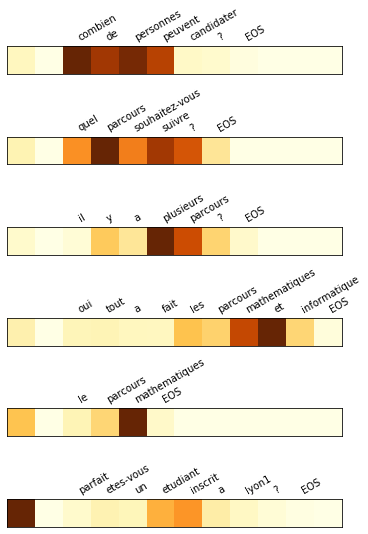

User :  non
target :  pour les etudiants du parcours mathematiques non-inscrits a lyon1 le nombre de places disponibles est de nbreplaces_en_france_mathematiques
predic :  pour les etudiants du parcours mathematiques non-inscrits a lyon1 le nombre de places disponibles est de nbreplaces_en_france_mathematiques


In [39]:
chatbot.eval()
dialogue = dialogues_Master_var[12][:4]
chatbot.showAttention(dialogue)

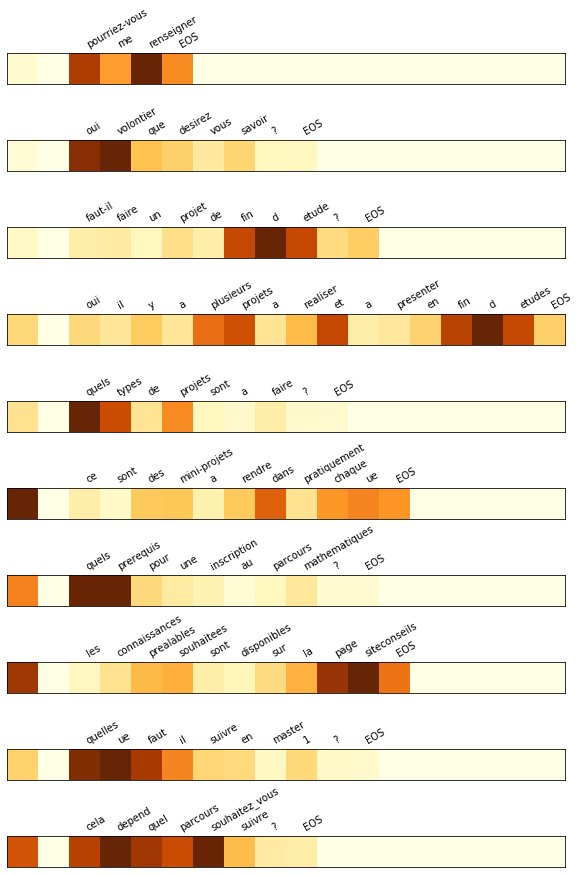

User :  le parcours informatique
target :  vous trouverez l ensemble des conseils concernants les connaissances prealables sur siteconseils
predic :  dans ce cas vous trouverez l ensemble des conseils concernants les connaissances prealables sur siteconseils


In [34]:
chatbot.eval()
dialogue = dialogues_Master_test_var[38][:6]
chatbot.showAttention(dialogue)

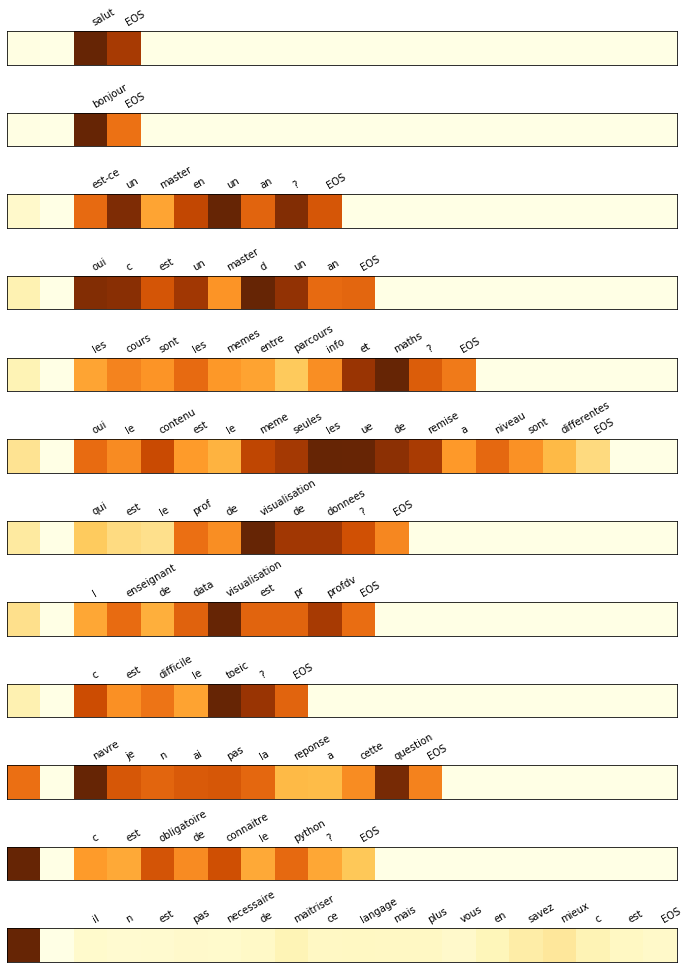

User :  il faut coder en php ?
target :  non aucun tp ne se fera en php
predic :  non aucun tp ne se fera en ruby


In [134]:
chatbot.eval()
dialogue = dialogues_Master_test_var[1][:7]
chatbot.showAttention(dialogue)

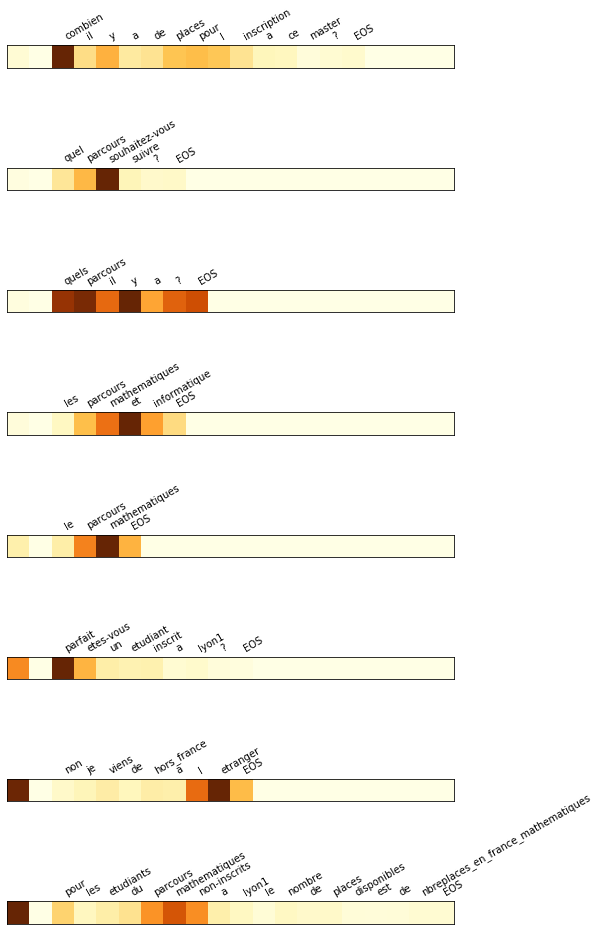

User :  a qui ce master est ouvert ?
target :  le master est ouvert aux etudiants titulaires d un master 1 en informatique mathematiques ou issus d un cursus ingenieur
predic :  le master est ouvert aux etudiants titulaires d un master 1 en informatique mathematiques ou issus d un cursus ingenieur


In [62]:
chatbot.eval()
dialogue = dialogues_Master_test_var[373][:5]
chatbot.showAttention(dialogue)

### 6.4.3 Interactive mode

write **quit** or **q** or **eoc** (end of conversation) to close conversation interface :

In [34]:
def ReplaceMotVar(motsVar, raw_sentence):
    sentence = []
    word_list = raw_sentence.split(' ')
    for word in word_list :
        if word in motsVar.keys() :
            sentence.append(motsVar[word])
        else :
            sentence.append(word)
    return ' '.join(sentence)

def InteractiveEvaluation(agent) :
    agent.initMemory()
    while True :
        text = input()
        #print('User : {}'.format(text))
        if text == 'eoc' or text == 'q' or text == 'quit' : 
            break
        reponse, attn1_weights, attn2_weights = chatbot(text)
        reponse = ReplaceMotVar(motsVar, reponse)
        print('Bot  : {}'.format(reponse))

In [65]:
chatbot.eval()
InteractiveEvaluation(chatbot)

salut ma poule
Bot  : bonjour
comment vas tu ?
Bot  : je vais bien merci et vous ?
ca va pas mal
Bot  : j en suis ravi en quoi puis-je vous aider ?
je voudrais savoir a quel point tu sais parler
Bot  : excellent vous etes au bon endroit
lol c'est bien répondu
Bot  : je vous en prie
j'aime les fruits au sirop
Bot  : je suis la pour vous aider
quit


In [23]:
chatbot.eval()
InteractiveEvaluation(chatbot)

salut toi
Bot  : bonjour
comment tu vas ?
Bot  : je vais bien merci et vous ?
oui ca va grave !
Bot  : j en suis ravi en quoi puis-je vous aider ?
tu aimes la musique ?
Bot  : je m appelle Horace
c'est moi qui pose les questions
Bot  : je vous en prie
je n'aime pas trop ce ton Horace
Bot  : c est dommage vous en aurez besoin si vous souhaitez faire ce master
ne me parle pas de master !
Bot  : cordialement
fort bien
Bot  : cordialement
quelle est ta couleur préférée ?
Bot  : vous pouvez consulter le calendrier des candidatures sur la plateforme e-candidat
quit


In [35]:
chatbot.eval()
InteractiveEvaluation(chatbot)

salut ma poule
Bot  : bonjour
qu'est ce que tu sais dire ?
Bot  : je vous encourage a vous renseigner sur le web
très bien comment j'y accède ?
Bot  : il vous suffit de suivre ce lien https://ecandidat.univ-lyon1.fr/#!accueilView
est ce qu'il y a des cours difficiles
Bot  : plusieurs supports de cours sont en anglais
j'aime pas les maths
Bot  : oui vous devez faire un depot de candidature sur la plateforme e-candidat
j'aimerais bien m'inscrire
Bot  : il faut malheureusement refaire un master 1 en informatique ou mathematiques
je ne veux pas la master en maths car je suis nul
Bot  : c est dommage vous en aurez besoin si vous souhaitez faire ce master
dis moi plutot comment s'inscrire au master info
Bot  : vous pouvez deposer une candidature si vous le souhaitez
non je suis a casablanca
Bot  : alors vous devez deposer votre candidature sur la plateforme e-candidat
quit
